In [1]:
# code taken and refined from: https://github.com/osh/KerasGAN

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from IPython import display
import tqdm
os.environ["KERAS_BACKEND"] = "tensorflow"
%matplotlib inline

from keras.datasets import mnist
from keras.utils.np_utils import to_categorical

# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training input shape: ", X_train.shape)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) #tf ordering, depth/channels at last index
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print("Training input shape reshaped: ",X_train.shape)
labels_train = to_categorical(y_train)
labels_test = to_categorical(y_test)
print("Training labels reshaped: ", labels_train.shape)

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


Training input shape:  (60000, 28, 28)
Training input shape reshaped:  (60000, 28, 28, 1)
Training labels reshaped:  (60000, 10)


In [2]:
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Activation, Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, UpSampling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

from keras.models import Model

def make_trainable(net,  val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [3]:
#Generative model

noise_inp = np.random.rand(1000,100)
nch = 200

g_opt = Adam(lr=1e-3)
g_inp = Input(shape=(100,))
H = Dense(nch*14*14,activation='relu',init='glorot_normal',input_shape=(100,))(g_inp)
H = Reshape((14,14,nch))(H)
H = BatchNormalization(mode=2)(H) # if using theano change axis argument here!!!
H = UpSampling2D(size=(2,2))(H)
H = Convolution2D(int(nch/2),3,3,border_mode='same',init='glorot_uniform',activation='relu')(H)
H = BatchNormalization(mode=2)(H)
H = Convolution2D(int(nch/4),3,3,border_mode='same',init='glorot_uniform',activation='relu')(H)
H = BatchNormalization(mode=2)(H)
#H = Convolution2D(1, 1, 1, border_mode='same', init='glorot_uniform')(H)
#pred = Activation('sigmoid')(H)
g_pred = Dense(1,init='glorot_uniform',activation='sigmoid')(H)

generator = Model(g_inp,g_pred)
generator.compile(loss='binary_crossentropy',optimizer=g_opt)
#generator.summary()

In [4]:
# discriminator
d_opt = Adam(lr=1e-4)
d_inp = Input(shape=X_train.shape[1:])

H = Convolution2D(128,3,3,activation='relu',input_shape=X_train.shape[1:])(d_inp)
H = Convolution2D(32, 3,3,activation='relu')(H)
H = MaxPooling2D(pool_size=(2,2))(H)
H = Dropout(0.5)(H)

# H = Convolution2D(512,5,5,subsample=(2,2),border_mode='same')(H)
# H = LeakyReLU(alpha=0.2)(H)
# H = Dropout(0.5)(H)

H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.1)(H)
H = Dropout(0.5)(H)
d_pred = Dense(2,activation='softmax')(H)
discriminator = Model(d_inp,d_pred)
discriminator.compile(loss='categorical_crossentropy',optimizer = d_opt)
#discriminator.summary()

In [5]:
# GAN, put together
#make_trainable(discriminator,False)
gan_inp = Input(shape=(100,))
H = generator(gan_inp)
gan_pred = discriminator(H)
GAN = Model(gan_inp,gan_pred)
GAN.compile(loss='categorical_crossentropy', optimizer = Adam(1e-3))
GAN.summary()

#helper fcts
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(5,4))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()
        

def plot_gen(n_ex=16,dim=(4,4), figsize=(5,5) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 28, 28, 1)     4185801     input_3[0][0]                    
____________________________________________________________________________________________________
model_2 (Model)                  (None, 2)             1218594     model_1[1][0]                    
Total params: 5,404,395
Trainable params: 5,403,695
Non-trainable params: 700
____________________________________________________________________________________________________


In [10]:
# pre train discriminator
make_trainable(discriminator,True)
num_samples= 10000
random_g_inp = np.random.uniform(0,1,size=(num_samples,100))
random_gen = generator.predict(random_g_inp)

X = np.concatenate((X_train[:num_samples,:,:,:],random_gen))
y = np.zeros((X.shape[0],2))
y[:num_samples,1]=1
y[num_samples:,0]=1

idx = np.random.permutation(num_samples*2)
print(str(X.shape) + ' labels: ' + str(y.shape))
discriminator.fit(X[idx],y[idx],nb_epoch=1,batch_size=32,validation_split=0.1)


(20000, 28, 28, 1) labels: (20000, 2)
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 11s - loss: 8.0277 - val_loss: 8.3411


In [7]:
# set up loss storage vector
losses = {"d":[], "g":[]}

def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm.trange(nb_epoch):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()

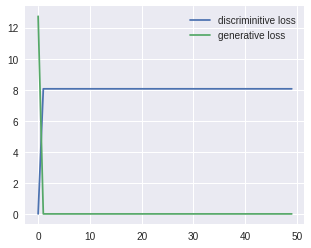

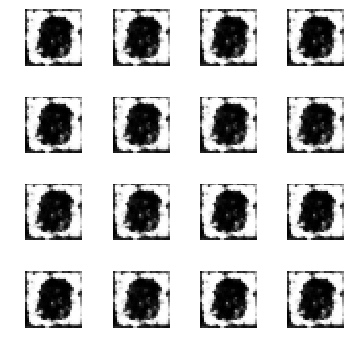

100%|██████████| 50/50 [00:38<00:00,  1.13it/s]


In [8]:
train_for_n(nb_epoch=50, plt_frq=5,BATCH_SIZE=128)

In [13]:
K.set_value(d_opt,lr=1e-4)

AttributeError: module 'keras' has no attribute 'set_value'